In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.loggers import CSVLogger

In [2]:
%%javascript
IPython.notebook.kernel.execute('notebook = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
notebook

'MNIST-Lightning-CSVLogger.ipynb'

In [4]:
class CNN_pl(pl.LightningModule):
    def __init__(self):
        super(CNN_pl, self).__init__()
        
        self.loss = nn.CrossEntropyLoss()
        self.lr = 0.01
        
        self.train_accm = torchmetrics.Accuracy()
        self.valid_accm = torchmetrics.Accuracy()
        self.train_acc = 0.
        self.avg_train_loss = 0.
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 10)
        )
            
    def forward(self, X):
        X = self.model(X)
        return X
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        output = self(inputs)
        loss_train = self.loss(output, targets)
        predictions = torch.argmax(output, dim=1)
        acc_train = self.train_accm(predictions, targets)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        output = self(inputs)
        loss_valid = self.loss(output, targets)
        predictions = torch.argmax(output, dim=1)
        acc_valid = self.valid_accm(predictions, targets)
        return {"loss": loss_valid, "p": predictions, "y": targets}
    
    def training_epoch_end(self, outputs):
        self.train_acc = self.train_accm.compute() * 100
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.train_accm.reset()
        
    def validation_epoch_end(self, outputs):
        valid_acc = self.valid_accm.compute() * 100
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f'Epoch {self.current_epoch+1}/{self.trainer.max_epochs} : Train Accuracy: {self.train_acc:.2f}%, Valid Accuracy: {valid_acc:.2f}%, Avg. Train Loss: {self.avg_train_loss:.4f}, Avg. Valid Loss: {avg_valid_loss:.4f}')
        metrics = {'epoch': self.current_epoch+1, 'Train Acc': self.train_acc, 'Train Loss': self.avg_train_loss,  'Valid Acc': valid_acc, 'Valid Loss': avg_valid_loss}
        self.logger.log_metrics(metrics)
        self.valid_accm.reset()
        if self.current_epoch == self.trainer.max_epochs - 1:
            self.validation_end(outputs)
    
    def validation_end(self, outputs):
        pb = [x['p'] for x in outputs]
        yb = [x['y'] for x in outputs]
        p = torch.cat(pb, 0).view(-1)
        y = torch.cat(yb, 0).view(-1)
        # confusion matrix here!
    
    def prepare_data(self):
        self.train_dataset = torchvision.datasets.MNIST(
                    root='.',
                    train=True,
                    transform=transforms.ToTensor(), # This will automatically normalize data!
                    download=True
                    )
        self.test_dataset  = torchvision.datasets.MNIST(
                    root='.',
                    train=False,
                    transform=transforms.ToTensor(), # This will automatically normalize data!
                    download=True
                    )
        
    def train_dataloader(self):
        train_ds = torch.utils.data.DataLoader(self.train_dataset,
                                               batch_size= 32,
                                               shuffle=True,
                                               num_workers=4)
        return train_ds
    
    def val_dataloader(self):
        test_ds = torch.utils.data.DataLoader(self.test_dataset,
                                               batch_size= 32,
                                               shuffle=False,
                                               num_workers=4)
        return test_ds

In [5]:
csvlogger = CSVLogger('csv_logs', name=notebook)
model = CNN_pl()
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger)
trainer.fit(model)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | train_accm | Accuracy         | 0     
2 | valid_accm | Accuracy         | 0     
3 | model      | Sequential       | 55.1 K
------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Epoch 1/20 : Train Accuracy: 0.00%, Valid Accuracy: 0.00%, Avg. Train Loss: 0.0000, Avg. Valid Loss: 2.3369


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 1/20 : Train Accuracy: 89.35%, Valid Accuracy: 94.78%, Avg. Train Loss: 0.3646, Avg. Valid Loss: 0.1680


Validating: 0it [00:00, ?it/s]

Epoch 2/20 : Train Accuracy: 94.78%, Valid Accuracy: 96.47%, Avg. Train Loss: 0.1702, Avg. Valid Loss: 0.1173


Validating: 0it [00:00, ?it/s]

Epoch 3/20 : Train Accuracy: 95.97%, Valid Accuracy: 96.38%, Avg. Train Loss: 0.1326, Avg. Valid Loss: 0.1138


Validating: 0it [00:00, ?it/s]

Epoch 4/20 : Train Accuracy: 96.51%, Valid Accuracy: 97.10%, Avg. Train Loss: 0.1122, Avg. Valid Loss: 0.0932


Validating: 0it [00:00, ?it/s]

Epoch 5/20 : Train Accuracy: 96.94%, Valid Accuracy: 97.35%, Avg. Train Loss: 0.0979, Avg. Valid Loss: 0.0875


Validating: 0it [00:00, ?it/s]

Epoch 6/20 : Train Accuracy: 97.13%, Valid Accuracy: 97.55%, Avg. Train Loss: 0.0910, Avg. Valid Loss: 0.0848


Validating: 0it [00:00, ?it/s]

Epoch 7/20 : Train Accuracy: 97.38%, Valid Accuracy: 97.37%, Avg. Train Loss: 0.0825, Avg. Valid Loss: 0.0889


Validating: 0it [00:00, ?it/s]

Epoch 8/20 : Train Accuracy: 97.52%, Valid Accuracy: 97.36%, Avg. Train Loss: 0.0762, Avg. Valid Loss: 0.0926


Validating: 0it [00:00, ?it/s]

Epoch 9/20 : Train Accuracy: 97.69%, Valid Accuracy: 97.23%, Avg. Train Loss: 0.0707, Avg. Valid Loss: 0.0940


Validating: 0it [00:00, ?it/s]

Epoch 10/20 : Train Accuracy: 97.76%, Valid Accuracy: 97.39%, Avg. Train Loss: 0.0696, Avg. Valid Loss: 0.0885


Validating: 0it [00:00, ?it/s]

Epoch 11/20 : Train Accuracy: 97.93%, Valid Accuracy: 97.39%, Avg. Train Loss: 0.0642, Avg. Valid Loss: 0.0913


Validating: 0it [00:00, ?it/s]

Epoch 12/20 : Train Accuracy: 98.11%, Valid Accuracy: 97.43%, Avg. Train Loss: 0.0584, Avg. Valid Loss: 0.0891


Validating: 0it [00:00, ?it/s]

Epoch 13/20 : Train Accuracy: 98.11%, Valid Accuracy: 97.56%, Avg. Train Loss: 0.0574, Avg. Valid Loss: 0.0875


Validating: 0it [00:00, ?it/s]

Epoch 14/20 : Train Accuracy: 98.22%, Valid Accuracy: 97.55%, Avg. Train Loss: 0.0549, Avg. Valid Loss: 0.0879


Validating: 0it [00:00, ?it/s]

Epoch 15/20 : Train Accuracy: 98.21%, Valid Accuracy: 97.55%, Avg. Train Loss: 0.0547, Avg. Valid Loss: 0.0912


Validating: 0it [00:00, ?it/s]

Epoch 16/20 : Train Accuracy: 98.23%, Valid Accuracy: 97.62%, Avg. Train Loss: 0.0519, Avg. Valid Loss: 0.0896


Validating: 0it [00:00, ?it/s]

Epoch 17/20 : Train Accuracy: 98.28%, Valid Accuracy: 97.62%, Avg. Train Loss: 0.0508, Avg. Valid Loss: 0.0893


Validating: 0it [00:00, ?it/s]

Epoch 18/20 : Train Accuracy: 98.39%, Valid Accuracy: 97.74%, Avg. Train Loss: 0.0492, Avg. Valid Loss: 0.0914


Validating: 0it [00:00, ?it/s]

Epoch 19/20 : Train Accuracy: 98.47%, Valid Accuracy: 97.67%, Avg. Train Loss: 0.0483, Avg. Valid Loss: 0.0905


Validating: 0it [00:00, ?it/s]

Epoch 20/20 : Train Accuracy: 98.41%, Valid Accuracy: 97.82%, Avg. Train Loss: 0.0486, Avg. Valid Loss: 0.0849


1

In [6]:
root='./csv_logs/' + notebook + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

In [7]:
metrics = metrics.drop(metrics.index[0])
metrics.head(10)

,epoch,Train Acc,Train Loss,Valid Acc,Valid Loss,step
1,1,89.349998,0.364606,94.779999,0.167994,1
2,2,94.779999,0.170160,96.470001,0.117321,2
3,3,95.974998,0.132601,96.380005,0.113795,3
4,4,96.513329,0.112181,97.099998,0.093193,4
5,5,96.941666,0.097870,97.349998,0.087480,5
6,6,97.128334,0.091012,97.549995,0.084837,6
7,7,97.375000,0.082549,97.369995,0.088889,7
8,8,97.518333,0.076250,97.360001,0.092588,8
9,9,97.693336,0.070664,97.229996,0.093978,9
10,10,97.758331,0.069565,97.389999,0.088459,10


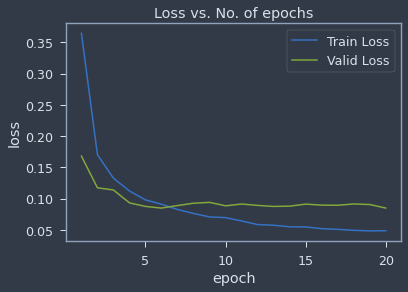

In [8]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Valid Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

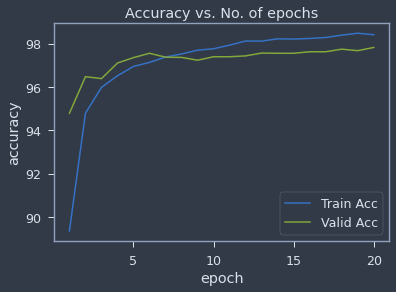

In [9]:
plt.plot(metrics['epoch'], metrics['Train Acc'], label="Train Acc")
plt.plot(metrics['epoch'], metrics['Valid Acc'], '-x', label="Valid Acc")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs. No. of epochs');